In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal
from google.colab import files
from IPython.display import HTML, display
import pandas as pd
from pandas import ExcelWriter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from os import walk

In [ ]:
module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/3")
input_size = 256 # fixed value, cannot be changed - max. resolution of TF model
movenet = module.signatures['serving_default']

In [ ]:
# low pass filter
def myFilter(vec):
  fs = 120 # sampling frequency
  fc = 6  # Cut-off frequency of the filter
  w = fc / (fs / 2) # Normalize the frequency
  b, a = signal.butter(2, w, 'low')
  output = signal.filtfilt(b, a, vec)  
  return output

# progress bar during serving phase
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
# Load the input video.
! rm -rf test*.* # delete previous data
filename = next(walk('./'), (None, None, []))[2]  # [] if no file
filename = filename[0]
vidcap = cv2.VideoCapture(filename)
v_length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))-1

In [ ]:
success = True
results = np.zeros((v_length,17,3)) # raw data
i=0
out = display(progress(0, 100), display_id=True)
    
for i in range(0,v_length):
  success,frame = vidcap.read()
  if success:
    cv2.imwrite("/content/%#02d.jpg" % (1), frame)
    image_path = '01.jpg'
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.cast(tf.image.resize_with_pad(input_image, input_size, input_size), dtype=tf.int32)
    outputs = movenet(input_image) # serving
    keypoint_with_scores = outputs['output_0']
    results[i,:,:] = keypoint_with_scores
    i+=1
    out.update(progress(i, v_length)) # show progress bar

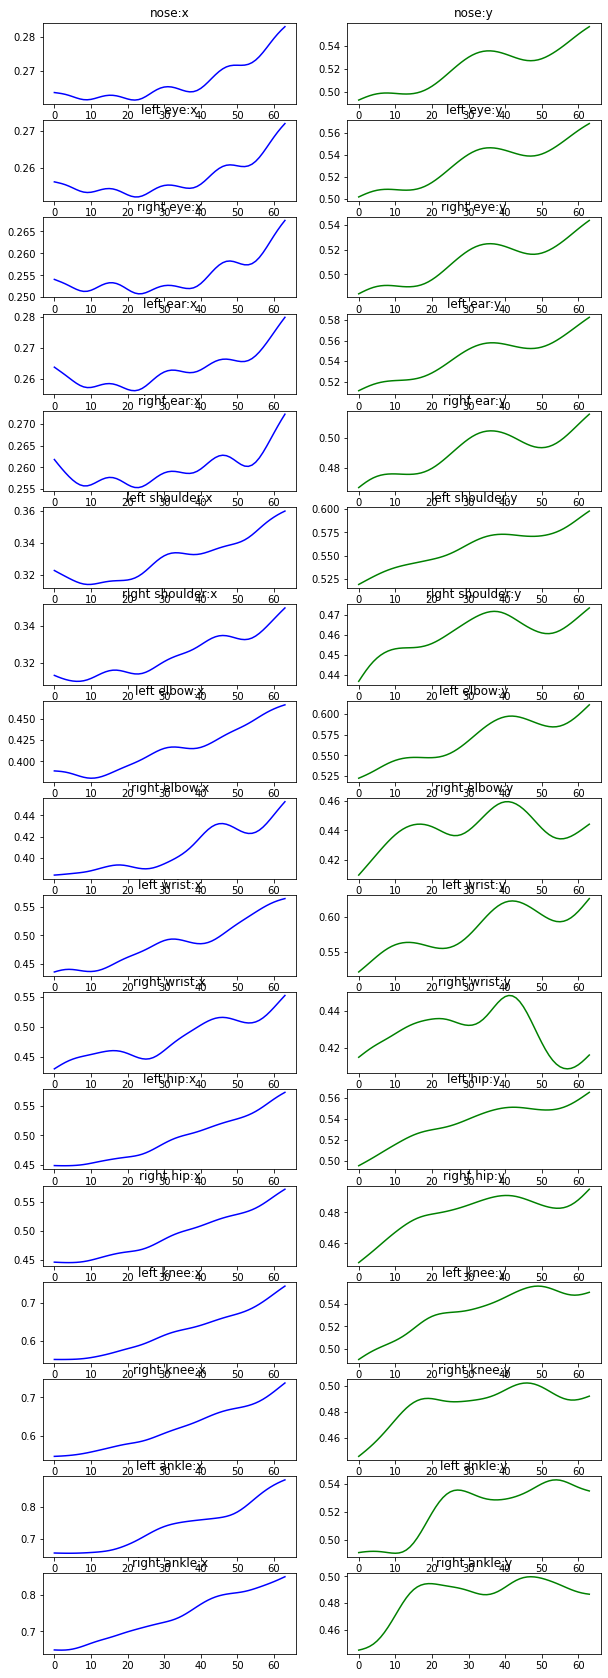

In [ ]:
labels = ['nose', 'left eye', 'right eye', 'left ear', 'right ear', 'left shoulder', 'right shoulder', 'left elbow', 'right elbow', 'left wrist', 'right wrist', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 'right ankle']
fig, axs = plt.subplots(17, 2,figsize=(10,30))
for i in range(0,17):
  axs[i, 0].plot(myFilter(results[:,i,0]),'b')
  axs[i,0].set_title(labels[i]+':x')   
  axs[i, 1].plot(myFilter(results[:,i,1]),'g')
  axs[i, 1].set_title(labels[i]+':y')  

In [ ]:
xlsout = np.zeros((v_length,34))
xlsLabels = ["" for x in range(34)]
for i in range(0,17):
  # prepare data: for all keypoints x,y -> 34 columns
  xlsout[:,i*2] = myFilter(results[:,i,0])
  xlsout[:,i*2+1] = myFilter(results[:,i,1])
  xlsLabels[i*2] = labels[i]+':x'
  xlsLabels[i*2+1] = labels[i]+':y'
df = pd.DataFrame(data=xlsout)
df.columns = xlsLabels
writer = ExcelWriter(filename+'_data.xlsx')
df.to_excel(writer,filename, index=False)
writer.save()
files.download(filename+'_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>